<a href="https://colab.research.google.com/github/nshea3/SEG_Facies_Classification/blob/master/SEG_Facies_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

data = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/training_data.csv')


In [0]:
import seaborn as sns

feature_names = [label for label in list(data.columns) if label not in ('Well Name','Facies','Formation', 'Depth')]

plot_columns = [label for label in list(data.columns) if label not in ('Formation', 'Well Name','Facies', 'Depth', 'NM_M')]


facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [3]:
from sklearn import preprocessing

X = data[feature_names].values
y = data['Facies'].values

imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

well = data['Well Name'].values
depth = data['Depth'].values

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows



X_aug, padded_rows = augment_features(X, well, depth)

In [0]:
from sklearn.model_selection import LeavePGroupsOut

# Initialize model selection methods
lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})



        
def preprocess():
    
    # Preprocess data to use in model
    X_train_aux = []
    X_test_aux = []
    y_train_aux = []
    y_test_aux = []
    
    # For each data split
    split = split_list[5]
        
    # Remove padded rows
    split_train_no_pad = np.setdiff1d(split['train'], padded_rows)

    # Select training and validation data from current split
    X_tr = X_aug[split_train_no_pad, :]
    X_v = X_aug[split['val'], :]
    y_tr = y[split_train_no_pad]
    y_v = y[split['val']]

    # Select well labels for validation data
    well_v = well[split['val']]

    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
        
    X_train_aux.append( X_tr )
    X_test_aux.append( X_v )
    y_train_aux.append( y_tr )
    y_test_aux.append (  y_v )
    
    X_train = np.concatenate( X_train_aux )
    X_test = np.concatenate ( X_test_aux )
    y_train = np.concatenate ( y_train_aux )
    y_test = np.concatenate ( y_test_aux )
    
    return X_train , X_test , y_train , y_test

X_train, X_test, y_train, y_test = preprocess()

In [6]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_aug, y, test_size=0.1, random_state=1)

In [0]:
blind_data = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.6516506189821183
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')


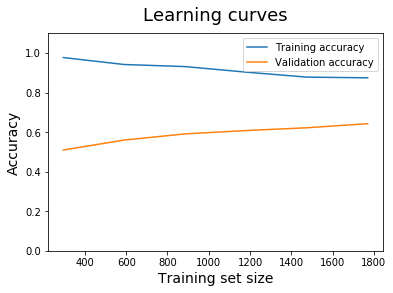

In [9]:
"""
This is the ExtraTreesClassifier

"""
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import learning_curve

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

train_sizes = list(range(295,2065,295))

def tv_scores_mean(estimator, X, y, train_sizes, scoring='accuracy', shuffle=True, cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(estimator = estimator, X=X, y=y, 
                                                                  train_sizes=train_sizes, scoring=scoring, 
                                                                  shuffle=shuffle, cv=cv)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    return train_sizes, train_scores_mean, validation_scores_mean

def plot_learning_curve(train_sizes, train_scores_mean, validation_scores_mean):
    plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1.1)

def randomizedsearch_helper(grid, estimator, X, y):
    gridsearch = model_selection.RandomizedSearchCV(estimator = estimator, param_distributions=grid)
    gridsearch.fit(X,y)
    return (gridsearch.best_estimator_, gridsearch.best_score_, gridsearch.best_params_)

def model_helper(grid, classifier, X, y, randomsearch = True):
    if randomsearch:
        est, acc, param = randomizedsearch_helper(grid, classifier, X, y)
    else:
        est, acc, param = gridsearch_helper(grid, classifier, X, y)
    est.fit(X_train,y_train)
    print(acc)
    print(est)
    return (est, acc, param)

cart_grid = {'max_depth' : range(3,10)}
result = model_helper(cart_grid, DecisionTreeClassifier(random_state=1), X_train, y_train)
cart_est = result[0]

plot_learning_curve(*tv_scores_mean(cart_est,X_train,y_train,train_sizes))

In [0]:
from sklearn.ensemble import GradientBoostingClassifier


rfc_grid = {'n_estimators' : range(100,300,50), 'min_samples_leaf': [6], 
            'min_samples_split':range(2,10,2), 'learning_rate':[0.03, 0.04, 0.05], 
            'subsample':[0.4, 0.6], 'max_depth':range(2,4,1)}


#Try n_estimators higher after this one 

def train_gbc(X_train, y_train, rfc_grid):
    result = model_helper(rfc_grid, GradientBoostingClassifier(random_state=1), X_train, y_train)
    gbc_est = result[0]
    plot_learning_curve(*tv_scores_mean(gbc_est,X_train,y_train,train_sizes))
    return gbc_est


#gbc_est = train_gbc(X_train, y_train, rfc_grid)

In [0]:
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier



def train_and_test(X_tr, y_tr, X_v, well_v, clf):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

In [12]:
#Load testing data

from sklearn.pipeline import make_pipeline, make_union
from scipy.signal import medfilt


test_data = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/validation_data_nofacies.csv')

from sklearn.model_selection import train_test_split

well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values


    
y_pred = []
print('.' * 100)
for seed in range(100):
    np.random.seed(seed)

    # Make training data.
    X_train, padded_rows = augment_features(X, well, depth)
    y_train = y
    X_train = np.delete(X_train, padded_rows, axis=0)
    y_train = np.delete(y_train, padded_rows, axis=0) 

    # Train classifier  
    clf = make_pipeline ( XGBClassifier(learning_rate=0.15, max_depth=8, min_child_weight=4, 
                                        n_estimators=148, seed=seed, colsample_bytree = 0.85, 
                                        subsample = 0.9 , gamma = 0.75) )

    # Make blind data.
    X_test, _ = augment_features(X_ts, well_ts, depth_ts)

    # Train and test.
    y_ts_hat = train_and_test(X_train, y_train, X_test, well_ts, clf)
    
    # Collect result.
    y_pred.append(y_ts_hat)
    print('|', end='')
    
np.save('LA_Team_100_realizations.npy', y_pred)

....................................................................................................
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

([array([  0., 178.,  88.,  76.,   0.,  60., 139.,  83., 194.,  12.]),
  array([  0., 183.,  85.,  68.,   0.,  63., 125.,  81., 214.,  11.]),
  array([  4., 178.,  85.,  70.,   0.,  55., 135.,  87., 207.,   9.]),
  array([  1., 183.,  83.,  72.,   0.,  51., 129.,  91., 209.,  11.]),
  array([  1., 175.,  92.,  79.,   0.,  55., 128.,  84., 210.,   6.]),
  array([  7., 176.,  84.,  73.,   0.,  48., 126.,  87., 220.,   9.]),
  array([  4., 173.,  89.,  72.,   0.,  61., 136.,  84., 199.,  12.]),
  array([  7., 171.,  89.,  70.,   0.,  63., 131.,  82., 206.,  11.]),
  array([  1., 184.,  83.,  75.,   0.,  55., 139.,  82., 200.,  11.]),
  array([  5., 180.,  81.,  79.,   0.,  58., 138.,  88., 190.,  11.]),
  array([  6., 179.,  82.,  70.,   0.,  58., 131.,  85., 209.,  10.]),
  array([  6., 180.,  80.,  76.,   0.,  65., 133.,  83., 192.,  15.]),
  array([  1., 175.,  91.,  72.,   0.,  52., 142.,  82., 204.,  11.]),
  array([  1., 182.,  83.,  69.,   0.,  57., 142.,  88., 199.,   9.]),
  arra

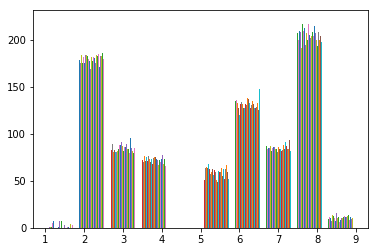

In [13]:
hist,bins = np.histogram(y_pred)
plt.hist(y_pred, bins)

In [0]:
from sklearn.metrics import confusion_matrix

PRED = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/prediction_depths.csv')
PRED.set_index(["Well Name", "Depth"], inplace=True)
PRED.head()

TRUE = pd.read_csv('https://raw.githubusercontent.com/seg/2016-ml-contest/master/blind_stuart_crawford_core_facies.csv')
TRUE.rename(columns={'Depth.ft': 'Depth'}, inplace=True)
TRUE.rename(columns={'WellName': 'Well Name'}, inplace=True)
TRUE.set_index(["Well Name", "Depth"], inplace=True)
TRUE.head()


def get_accuracies(y_preds):
    """
    Get the F1 scores from all the y_preds.
    y_blind is a 1D array. y_preds is a 2D array.
    """
    accs = []
    for y_pred in y_preds:
        PRED['Facies'] = y_pred
        all_data = PRED.join(TRUE, how='inner')
        y_blind = all_data['LithCode'].values
        y_pred = all_data['Facies'].values
        y_pred = y_pred[y_blind!=11]
        y_blind = y_blind[y_blind!=11]
        cv_conf = confusion_matrix(y_blind, y_pred)
        #sns.heatmap(cv_conf, annot=True, fmt="d")
        accs.append(accuracy(cv_conf))
    return np.array(accs)

LA                  0.5800


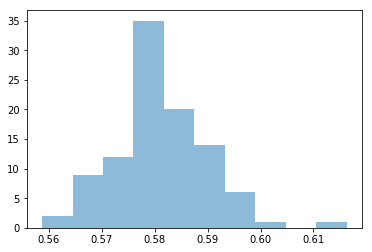

In [19]:
from os import path
import operator


def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

scores, medians = {}, {}
for f in ['LA_Team_100_realizations.npy']:
    team = path.basename(f).split('_')[0]
    y_preds = np.load(f)
    scores[team] = get_accuracies(y_preds)
    medians[team] = np.median(scores[team])
    plt.hist(pd.Series(scores[team]), alpha=0.5)

for t, m in sorted(medians.items(), key=operator.itemgetter(1), reverse=True):
    print("{:20s}{:.4f}".format(t, m))